In [1]:
import pandas as pd
import numpy as np
from utils import load_data, train_dev_split
import os
from collections import defaultdict
import matplotlib.pyplot as plt


RANDOM_SEED = 61273812

DATA_PATH = '/'.join(os.getcwd().split('/')[:-2]) + '/datav2/'
DATA_ES_PATH = DATA_PATH + 'esp/'
DATA_POR_PATH = DATA_PATH + 'por/'

MODEL_PATH = '/'.join(os.getcwd().split('/')[:-2]) + '/pretrained_models/'

In [2]:
nclasses = 5
df = load_data(DATA_ES_PATH,'train',nclasses)

df

,review_content,review_rate
0,"Esta de muy baja calidad, no fue lo esperado.",1
1,"Reconozco que fue muy económico, pero su durab...",1
2,Muy bien muy bien muy bien muy bien muy bien m...,4
3,No me fue útil para mí. Diseño muy bueno.,1
4,No fue lo estipulado. Solo eso voy aclarar.,0
...,...,...
462363,"Bien, bien, bien, bien, bien, bien, bien, bien...",2
462364,Acorde al precio.,1
462365,No funciono.,1
462366,Buen producto. Y muy completo a un precio muy ...,3


<AxesSubplot:>

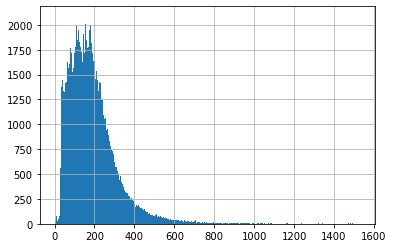

In [3]:
df['review_content'].str.len().hist(bins=1600)

In [4]:
df.loc[(df['review_content'].str.len() > 600),'review_rate'].value_counts().sort_index()

0     362
1     444
2    1040
3    1629
4    2864
Name: review_rate, dtype: int64

In [5]:
df.loc[(df['review_content'].str.len() < 600),'review_rate'].value_counts().sort_index()

0    92109
1    92002
2    91441
3    90856
4    89574
Name: review_rate, dtype: int64

/home/lestien/anaconda3/envs/nlpenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lestien/anaconda3/envs/nlpenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


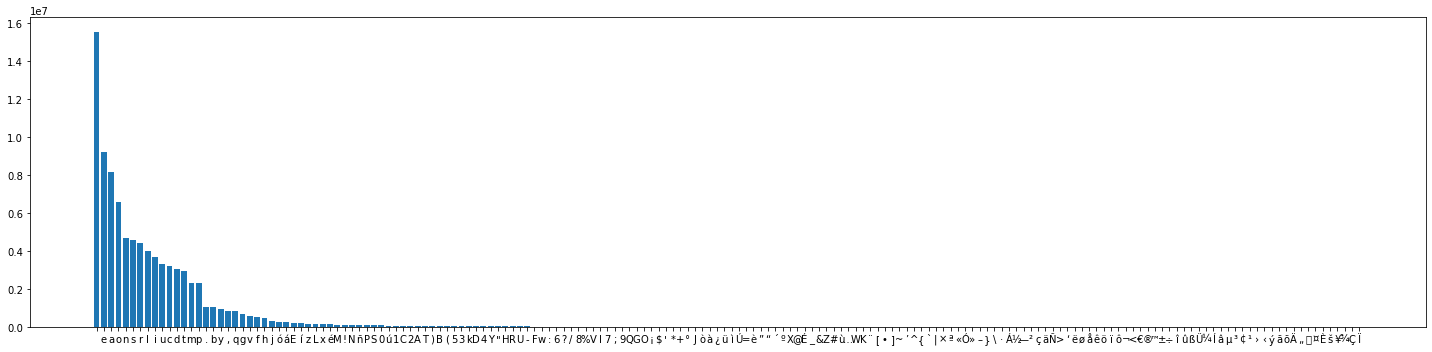

In [6]:
charcounts = defaultdict(lambda: 0)
for sent in df['review_content']:
    for char in sent:
        charcounts[char] += 1

charcounts = pd.Series(dict(charcounts),index=list(charcounts.keys())).sort_values(ascending=False)

fig, ax = plt.subplots(1,1,figsize=(20,5))
ticks = np.arange(len(charcounts))
ax.bar(ticks, charcounts)
ax.set_xticks(ticks)
ax.set_xticklabels(charcounts.index,fontsize='medium')
# ax.set_yscale('log')
fig.tight_layout()
plt.savefig('charcounts.png')

In [21]:
def pretokenize_dataset(ds):
    
    # Pasamos a minúscula todo
    ds = ds.str.lower()
    
    # Sacamos todos los acentos
    accents = [
        ('[óòÓöøôõ]','o'), ('[áàÁäåâãÄ]','a'), ('[íìÍïîÏ]','i'), 
        ('[éèÉëêÈ]','e'), ('[úüÚùûÜ]','u'), ('[ç¢Ç]','c'), 
        ('[ý¥]','y'),('š','s'),('ß','b'),('\x08','')
    ]
    
    for rep, rep_with in accents:
        ds  = ds.str.replace(rep,rep_with,regex=True)
        
    pattern = r"(\w+|[\.,!\(\)\"\-:\?/%;¡\$'¿\\]|\d+)"
    ds = ds.str.findall(pattern)
    return ds


ds = pretokenize_dataset(df['review_content'])
wordcounts = defaultdict(lambda: 0)
for sent in ds:
    for word in sent:
        wordcounts[word] += 1

wordcounts = pd.Series(dict(wordcounts),index=list(wordcounts.keys())).sort_values(ascending=False)

In [22]:
wordcounts

.                                                                                                                                                                                                                                                                                                                                                   1068769
,                                                                                                                                                                                                                                                                                                                                                    815459
de                                                                                                                                                                                                                                                                                                              

In [23]:
wordcounts[wordcounts > 1]

.               1068769
,                815459
de               578156
que              545717
la               516333
                 ...   
turoriales            2
helicobacter          2
205º                  2
esperabs              2
magro                 2
Length: 68849, dtype: int64

In [28]:
ds = df.loc[df['review_content'].str.len() < 100, 'review_content']

ds = pretokenize_dataset(ds)
wordcounts = defaultdict(lambda: 0)
for sent in ds:
    for word in sent:
        wordcounts[word] += 1

wordcounts = pd.Series(dict(wordcounts),index=list(wordcounts.keys())).sort_values(ascending=False)

In [29]:
wordcounts

.              145491
no              75867
,               54561
la              41431
de              38312
                ...  
sensa               1
ahorrara            1
amigurumis          1
minproducto         1
1000mbps            1
Length: 35002, dtype: int64

In [30]:
wordcounts[wordcounts > 1]

.            145491
no            75867
,             54561
la            41431
de            38312
              ...  
adaptarle         2
errado            2
podologia         2
invalido          2
adelgazo          2
Length: 16462, dtype: int64

In [3]:
from transformers import BertConfig, BertTokenizer
import json

def bert_tokenize_dataset(ds,cased=True):
    
    if not cased:
        # Pasamos a minúscula todo
        ds = ds.str.lower()
    # Sacamos todos los acentos
    accents = [
        ('[óòÓöøôõ]','ó'), ('[áàÁäåâãÄ]','á'), ('[íìÍïîÏ]','í'), 
        ('[éèÉëêÈ]','é'), ('[úÚùû]','ú'), ('[ç¢Ç]','c'), ('[ý¥]','y'),
        ('š','s'), ('ß','b'), ('\x08','')
    ]
    for rep, rep_with in accents:
        ds  = ds.str.replace(rep,rep_with,regex=True)
    
    if cased:
        model_path = MODEL_PATH + 'beto_cased/'
        do_lower_case = False
    else:
        model_path = MODEL_PATH + 'beto_uncased/'
        do_lower_case = True

    tokenizer = BertTokenizer.from_pretrained(model_path,do_lower_case=do_lower_case)
    ds_tokenized = ds.apply(tokenizer.tokenize)
    return ds_tokenized


ds = bert_tokenize_dataset(df['review_content'],cased=False)
wordcounts = defaultdict(lambda: 0)
for sent in ds:
    for word in sent:
        wordcounts[word] += 1

wordcounts = pd.Series(dict(wordcounts),index=list(wordcounts.keys())).sort_values(ascending=False)

In [4]:
wordcounts

.               1068769
,                815459
de               578455
que              546047
la               516865
                 ...   
liderar               1
##ulia                1
nacionalista          1
##rimon               1
milton                1
Length: 22025, dtype: int64

In [5]:
wordcounts[wordcounts > 1]

.               1068769
,                815459
de               578455
que              546047
la               516865
                 ...   
fao                   2
##osten               2
1931                  2
indiferencia          2
beck                  2
Length: 20454, dtype: int64

In [6]:
from collections import Counter
ds.apply(Counter).apply(lambda d: d.get('[UNK]',0)).value_counts()

0      433394
1       23715
2        3695
3         830
4         378
5         138
6          84
7          36
8          28
9          17
11          9
10          7
13          5
16          5
12          5
14          4
27          4
18          2
17          1
20          1
21          1
29          1
30          1
32          1
60          1
578         1
333         1
87          1
102         1
104         1
Name: review_content, dtype: int64